In [38]:
from MainFiles.GP import *
from Windowing import *
import torch
from Windowing import *
from torch.linalg import inv, det
import torch.distributions as tdb

# Introduction
We now try the original thing again but with the better cov_kernel function

# Method

In [2]:
win = Windowing(aggCurves)
win.set_points([16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448, 2048, 2896])

,Count
size_train,
16,245
23,246
32,246
40,1
45,244
...,...
1048576,2
1482910,1
1486391,1


In [3]:
y = torch.tensor(win.data, dtype=torch.float)
X = torch.tensor(win.train_anchors, dtype=torch.float32)

In [4]:
def optimize_params(params, y, X, lr = 0.001, n_iter = 100):
    '''
    Optimise the hyperparameters for the GP

    :param params: initial parameters for the covariance kernel and mean function
    :param y: actual outputs
    :param X: training anchors
    :param lr: learning rate
    :param n_iter: number of iterations
    :return: optimised parameters
    '''
    params = params.clone().requires_grad_(True)
    optimizer = torch.optim.AdamW([params], lr=lr)
    gr = torch.ones(params.shape[1:])

    for i in range(n_iter):
        optimizer.zero_grad()
        loss = -log_marginal_likelihood(params, y, X)
        loss.backward(gradient=gr)
        optimizer.step()
        print(f'Iteration {i} marginal likelihood: {np.exp(-loss.mean().item())}')
    return params

In [7]:
params = torch.tensor([0.5,0.5,0.5, 0.5], dtype=torch.float32)
shp = np.hstack((np.array(y.shape[:2]), np.array(y.shape[3])))
params = params.repeat(*shp, 1)

# params at front
params = params.permute(*np.roll(np.arange(len(params.shape)),1))

params = optimize_params(params, y, X, lr = 0.1, n_iter = 50)

Iteration 0 marginal likelihood: 0.684665147298796
Iteration 1 marginal likelihood: 0.881970839894196
Iteration 2 marginal likelihood: 0.9518115682244522
Iteration 3 marginal likelihood: 0.9733848866226816
Iteration 4 marginal likelihood: 0.979259820074013
Iteration 5 marginal likelihood: 0.9804559537613687
Iteration 6 marginal likelihood: 0.9803873990512985
Iteration 7 marginal likelihood: 0.9797502614019555
Iteration 8 marginal likelihood: 0.9788407860953964
Iteration 9 marginal likelihood: 0.9783258054037545
Iteration 10 marginal likelihood: 0.9774074517115334
Iteration 11 marginal likelihood: 0.9776413310383262
Iteration 12 marginal likelihood: 0.9756077361583094
Iteration 13 marginal likelihood: 0.9776278648443304
Iteration 14 marginal likelihood: 0.9763428785901629
Iteration 15 marginal likelihood: 0.9768963603006758
Iteration 16 marginal likelihood: 0.9772512653268361
Iteration 17 marginal likelihood: 0.9775345243625527
Iteration 18 marginal likelihood: 0.9778180093865989
Iterat

# Now for one curve
Redefine some stuff

In [52]:
def log_marginal_likelihood(params, y, X):
    '''
    Log marginal likelihood for optimization of hyperparameters for GP

    :param params: arameters for the covariance kernel and mean function
    :param y: actual outputs
    :param X: training anchors
    :return: log marginal likelihood
    '''
    # set mean
    mean = params[0]

    # make nans 0
    y = y - mean
    # nan = torch.isnan(y)
    # nanT = nan.transpose(-1, -2)
    # nan_ind = torch.where(nanT)
    # y = torch.where(nan, torch.tensor(0.0), y)
    # yT = y.transpose(-1, -2)

    # get covariance matrix and set rows/columns where nan to 0 as these are technically not datapoints
    cov = cov_kernel(X, X[..., None], params[1:])
    # cov[nanT, :] = 0
    # cov.transpose(-1, -2)[nanT, :] = 0
    # cov[nan_ind[0], nan_ind[1], nan_ind[2], nan_ind[3], nan_ind[
    #     3]] = 1  # The trick is to set the "fake" datapoints diagonal to 1 and rest of its row and column to 1,
    # # this way it is like it's not there for the determinant and inverse
    inv_cov = inv(cov)

    # calculate the matrix multiplication
    matmul = torch.einsum('...i,...ij,...j', y, inv_cov, y)

    res = -1 / 2 * matmul
    return res

In [53]:
def optimize_params(params, y, X, lr = 0.001, n_iter = 100):
    '''
    Optimise the hyperparameters for the GP

    :param params: initial parameters for the covariance kernel and mean function
    :param y: actual outputs
    :param X: training anchors
    :param lr: learning rate
    :param n_iter: number of iterations
    :return: optimised parameters
    '''
    params = params.clone().requires_grad_(True)
    optimizer = torch.optim.AdamW([params], lr=lr)
    # gr = torch.ones(params.shape[1:])

    losses = []
    for i in range(n_iter):
        optimizer.zero_grad()
        loss = -log_marginal_likelihood(params, y, X)
        losses.append(loss.detach().numpy())
        if i % 10 == 0:
            print(f'Iteration {i} loss: {loss.item()}')
        loss.backward()
        optimizer.step()

        if len(losses) > 10:
            if np.mean(losses[-10:]) == losses[-1]:
                print("Stopped at iteration: ",i)
                break

    return params, losses

In [54]:
cut = y[[0,1],0,:,-1]

In [55]:
params = torch.tensor([0.5,0.5,0.5, 0.5], dtype=torch.float32)
params, losses = optimize_params(params, cut[0], X, lr = 0.01, n_iter = 10000)

Iteration 0 loss: 2.2514023780822754
Iteration 10 loss: 0.8274351358413696
Iteration 20 loss: 0.3571223318576813
Iteration 30 loss: 0.196620374917984
Iteration 40 loss: 0.13437102735042572
Iteration 50 loss: 0.10606352984905243
Iteration 60 loss: 0.09099937975406647
Iteration 70 loss: 0.08180364966392517
Iteration 80 loss: 0.07555307447910309
Iteration 90 loss: 0.07096251100301743
Iteration 100 loss: 0.06740568578243256
Iteration 110 loss: 0.06454425305128098
Iteration 120 loss: 0.06217731535434723
Iteration 130 loss: 0.06017540395259857
Iteration 140 loss: 0.05844971165060997
Iteration 150 loss: 0.05693645775318146
Iteration 160 loss: 0.05558842048048973
Iteration 170 loss: 0.05436985567212105
Iteration 180 loss: 0.053253449499607086
Iteration 190 loss: 0.052218277007341385
Iteration 200 loss: 0.051248252391815186
Iteration 210 loss: 0.05033114552497864
Iteration 220 loss: 0.04945765435695648
Iteration 230 loss: 0.0486207976937294
Iteration 240 loss: 0.04781532287597656
Iteration 250 

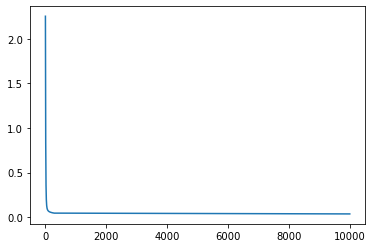

In [35]:
plt.plot(losses)

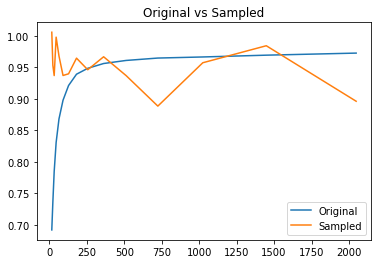

In [62]:
# Now lets compare
plt.plot(X,cut[0], label="Original")

# We sample 1000 times and take the mean
means = params[0].repeat(X.shape[0])
cov = cov_kernel(X,X[...,None],params[1:])

S = tdb.MultivariateNormal(means,cov).sample(sample_shape=torch.Size([1000])).mean(0)
plt.plot(X,S, label="Sampled")

plt.title("Original vs Sampled")
plt.legend()


# Conclusion
Doesn't seem to work as well, lets try with the other method